# 神经网络与深度学习实验四
## 附加题：使用lstm实现文本分类（与GNN形成对照）

## 零、配置环境

In [89]:
!pip install torch
!pip install pandas
!pip install matplotlib
!pip install tqdm
!pip install numpy

## 一、导入模块
------

In [90]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F

## 二、读取数据表格
------

In [91]:
df = pd.read_csv('datasets/r8/r8.csv')
documents = df['text'].tolist()
labels = df['intent'].tolist()
label2idx = {label: idx for idx, label in enumerate(df['intent'].unique().tolist())}

## 三、生成随机嵌入
------

In [92]:
embed_dim = 64
num_classes = len(label2idx)  # 类别的数量

unique_words = set(" ".join(documents).split(" "))  # 长度为14575的词表
embeddings = np.random.rand(len(unique_words)+1, embed_dim)  # 生成embed_dim维度的随机嵌入
embeddings[-1, :] = 0
word2index = {word: idx for idx, word in enumerate(unique_words)}

## 可视化序列长度直方图

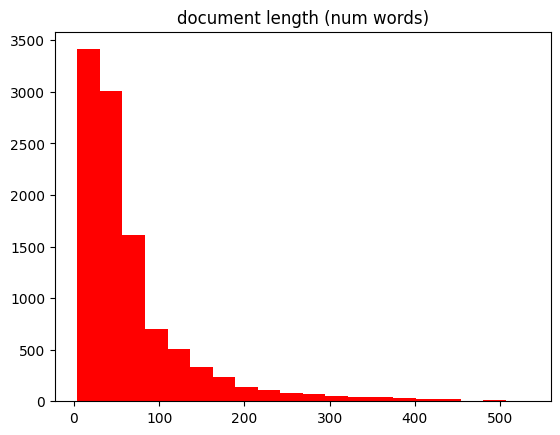

In [93]:
lengths = [len(document.split(' ')) for document in documents]
plt.hist(lengths, bins=20, color='r')
plt.title('document length (num words)')
plt.show()

## 四、构建数据集
------

In [94]:
class DocumentDataset(Dataset):
    def __init__(self, documents, labels, seq_len):
        self.documents = documents
        self.labels = labels
        self.seq_len = seq_len

    def __len__(self):
        return len(self.documents)

    def __getitem__(self, index):
        document = self.documents[index]
        label = label2idx[self.labels[index]]
        
        # Split the document into words and convert to indices
        word_indices = np.array([word2index.get(word, 0) for word in document.split(' ')])
        
        # Pad or truncate the sequence
        if len(word_indices) < self.seq_len:
            word_indices = np.pad(word_indices, (0, self.seq_len - len(word_indices)), 'constant')
        else:
            word_indices = word_indices[:self.seq_len]

        # Convert indices to embeddings
        document = embeddings[word_indices]

        return torch.tensor(document, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

## 五、搭建lstm模型
------

In [95]:
class LSTM(torch.nn.Module):
    name = 'lstm'
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = torch.nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # 最后一个时间步的隐藏状态做分类
        out = self.fc2(F.relu(out))

        return out

### 检查cuda是否可用

In [96]:
torch.cuda.is_available()

True

## 六、开始模型训练
------

In [97]:
cut_point = int(len(documents) * 0.8)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

train_set = DocumentDataset(documents[:cut_point], labels[:cut_point], seq_len=100)
val_set = DocumentDataset(documents[cut_point:], labels[cut_point:], seq_len=100)

model = LSTM(embed_dim, 64, num_classes, num_layers=2)
model.to(device)

train_loader = DataLoader(train_set, batch_size=64)
val_loader = DataLoader(val_set, batch_size=64)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 500

losses = []
val_accuracies = []

p_bar = tqdm(range(epochs))
val_accuracy = 0.
best_acc = 0.

for epoch in p_bar:
    running_loss = 0.
    correct = 0
    total = 0
    
    for i, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x)
        optimizer.zero_grad()
        loss = F.cross_entropy(y_pred, y)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        p_bar.set_postfix(loss=running_loss/(i+1), progress=f"{i/len(train_loader)*100:.2f}%", val_acc=f"{val_accuracy*100:.2f}%", best_acc=best_acc)
        p_bar.set_description(f"epoch {epoch}")
        
    losses.append(running_loss)
        
    for i, (x, y) in enumerate(val_loader):
        x = x.to(device)
        y = y.to(device)
        with torch.no_grad():
            y_pred = model(x)
            total += x.shape[0]
            correct += (y_pred.max(dim=1)[1] == y).sum().item()
            
    val_accuracy = accuracy = correct / total
    val_accuracies.append(accuracy)
    if val_accuracy > best_acc:
        best_acc = val_accuracy
    
torch.save(model.state_dict(), f'model_{model.name}_state_dict.pt')
    

epoch 499: 100%|██████████| 500/500 [06:05<00:00,  1.37it/s, loss=0.00105, progress=99.24%, val_acc=96.35%] 


## 七、可视化训练过程
------

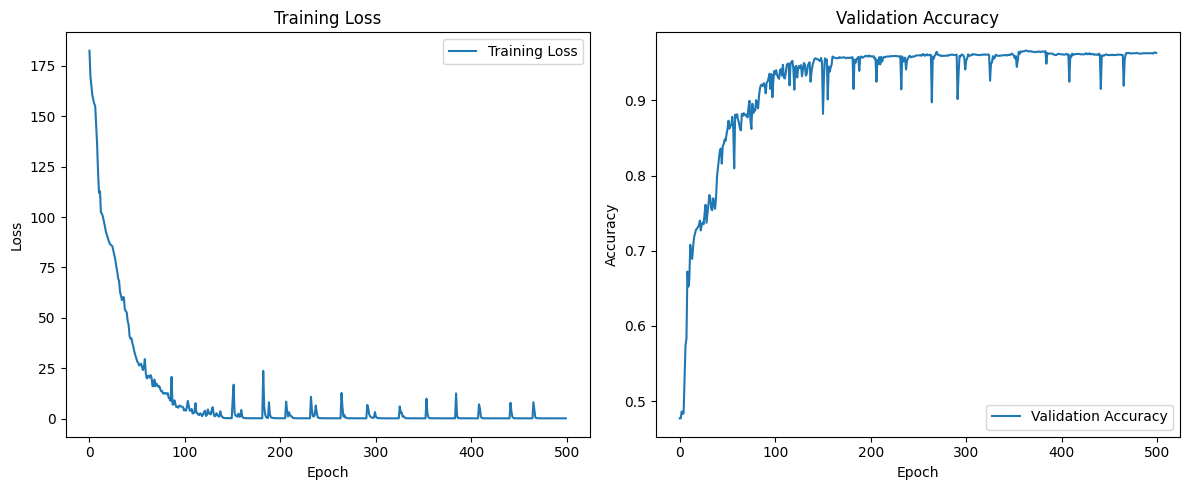

In [98]:
plt.figure(figsize=(12, 5))

# 绘制损失
plt.subplot(1, 2, 1)
plt.plot(losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 绘制验证准确率
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [98]:
print('the end...')